## **How to increase customer satisfaction (so as to increase profit margin) while maintaining a healthy order volume?** ❓

Olist is a leading e-commerce service that connects merchants to main marketplaces in Brazil. They provide a wide range of offers including inventory management, dealing with reviews and customer contacts to logistic services.

Olist charges sellers a monthly fee. This fee is progressive with the volume of orders.

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers.

Kaggle dataset = https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

### Data Preparation

#### Imports

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

import plotly
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [3]:
#load data in 
from package.seller import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers.head(2)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score,reputation_cost,revenue,profit
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00,140,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.725000,4.55,240,2290.307,2050.307


In [4]:
from package.order import Order
orders = Order().get_training_data(with_distance_seller_customer=False)

In [5]:
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72


#### Costs and Revenue

**Revenues**  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

**Costs**
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

In order to calculate the profit, we need to first calculate the revenue and costs.

**Revenue** is made up of sales fees and subscription fees.

In [6]:
# Revenues
revenues_sales = sellers.sales.sum() * 0.1
revenues_subscription = sellers.months_on_olist.sum() * 80

revenues_total = revenues_sales + revenues_subscription

print(
    f'''
Revenues: {revenues_total:.2f} BRL
- Sales: {revenues_sales:.2f} BRL
- Subscriptions: {revenues_subscription:.2f} BRL
''')


Revenues: 2785818.44 BRL
- Sales: 1355578.44 BRL
- Subscriptions: 1430240.00 BRL



**Costs** consist of reputation costs + IT costs

In [7]:
#Costs
reputation_cost = sellers.reputation_cost.sum()

In [8]:
costs_it = 500_000

costs_total = reputation_cost + costs_it

print(
    f'''
Costs: {costs_total:.2f} BRL
- Reviews: {reputation_cost:.2f} BRL
- IT: {costs_it:.2f} BRL
''')


Costs: 2118210.00 BRL
- Reviews: 1618210.00 BRL
- IT: 500000.00 BRL



#### Profit

In [9]:
# Gross Profit, before IT costs
profits_gross = revenues_total - reputation_cost

profits_gross

1167608.4440000001

In [10]:
# Gross Profit, after IT costs
profits_net = profits_gross - costs_it

profits_net

667608.4440000001

### Analysis

#### Review Score

In [11]:
Seller().data["order_reviews"].review_score.value_counts(normalize = True)

5    0.577763
4    0.192917
1    0.115133
3    0.082430
2    0.031756
Name: review_score, dtype: float64

We can observe that there are approx. 23% of review scores 3 or below.

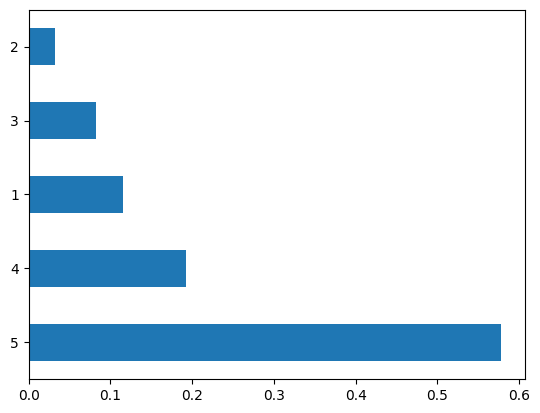

In [12]:
Seller().data["order_reviews"].review_score.value_counts(normalize=True).plot(kind='barh');

#### Feature Analysis

In [13]:
orders.describe()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
count,96353.000000,96353.000000,96353.000000,96353.000000,96353.000000,96353.000000,96353.000000,96353.000000,96353.000000,96353.000000
mean,12.522869,23.741881,-0.754903,0.592187,0.097610,4.155688,1.141687,1.013918,136.654623,22.757810
std,9.457183,8.759019,4.656481,0.491431,0.296788,1.284979,0.535362,0.123616,207.444085,21.496018
min,0.533414,2.008009,-188.975081,0.000000,0.000000,1.000000,1.000000,1.000000,0.850000,0.000000
25%,6.763530,18.335243,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,45.900000,13.840000
50%,10.211944,23.233113,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,86.000000,17.160000
75%,15.685278,28.411979,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,149.900000,23.990000
max,208.351759,155.135463,0.000000,1.000000,1.000000,5.000000,21.000000,5.000000,13440.000000,1794.960000


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96353 entries, 0 to 96360
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            96353 non-null  object 
 1   wait_time           96353 non-null  float64
 2   expected_wait_time  96353 non-null  float64
 3   delay_vs_expected   96353 non-null  float64
 4   order_status        96353 non-null  object 
 5   dim_is_five_star    96353 non-null  int64  
 6   dim_is_one_star     96353 non-null  int64  
 7   review_score        96353 non-null  int64  
 8   number_of_products  96353 non-null  int64  
 9   number_of_sellers   96353 non-null  int64  
 10  price               96353 non-null  float64
 11  freight_value       96353 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


<AxesSubplot:>

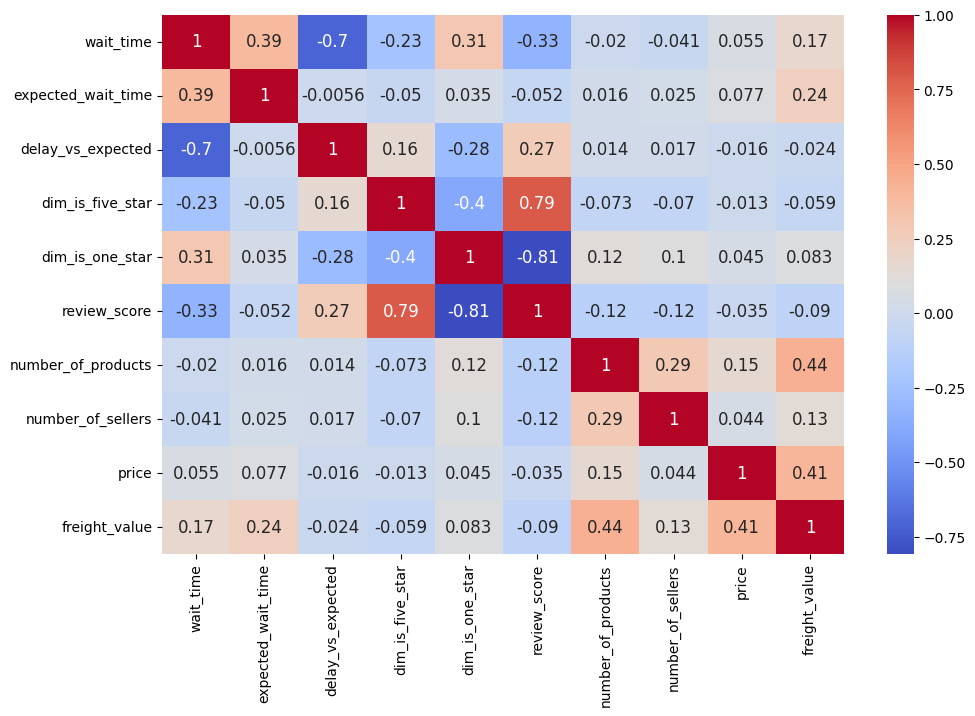

In [15]:
# Correlation plot 
plt.figure(figsize=(11,7))
sns.heatmap(orders.corr(), cmap='coolwarm', annot = True, annot_kws={"size": 12})

In [16]:
round(np.abs(orders.corr()['review_score']).sort_values(ascending = False),2)

review_score          1.00
dim_is_one_star       0.81
dim_is_five_star      0.79
wait_time             0.33
delay_vs_expected     0.27
number_of_products    0.12
number_of_sellers     0.12
freight_value         0.09
expected_wait_time    0.05
price                 0.03
Name: review_score, dtype: float64

**Findings**


As expected the most correlated features are review score related features, i.e `review_score`, `dim_is_one_star` and `dim_is_five_star`.

The two next highest correlation coefficients with respect to the `review_score` are :
   * `wait_time` : - 34 %
   * `delay_vs_expected` : - 27 %

Closer look at these two features.

In [17]:
sample = orders.sample(10000, random_state=42)

(0.0, 5.987707776920748)

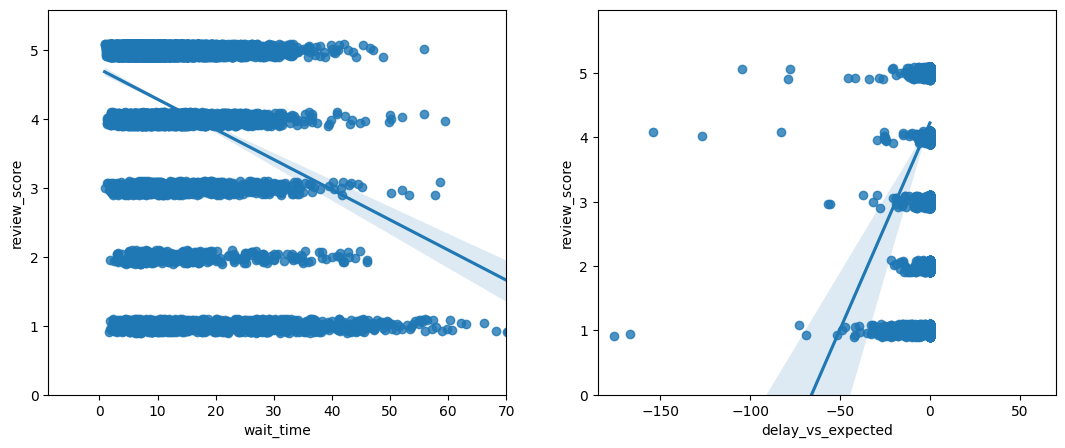

In [18]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = sample.delay_vs_expected, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

Broad interpretation is the longer the wait time or delay, the lower the review score.

#### Underperforming Sellers

In [19]:
sellers_trim = sellers[['seller_id','months_on_olist','review_score','reputation_cost', 'revenue', 'profit','quantity']]
sellers_df = sellers_trim.copy()

Built a function to assess the impact on total profit for Olist, based on selecting indivudal seller profit.

In [20]:
def sellers_profit(sellers_df,minimum = 0):
    for index, value in sellers_df[["profit"]].iterrows():
        if value[0]<minimum:
            sellers_df.drop([index], inplace=True)
    
    alpha = 3157.27
    beta = 978.23

    total_sellers_c = sellers_df.seller_id.count()
    total_products_c = sellers_df.quantity.sum()
    sellers_df["total_it_costs"] = alpha*(total_sellers_c**0.5) + beta*(total_products_c**0.5)
    return sellers_df

This function is to calculate the total profit with the selected sellers.

In [21]:
def total_profit(sellers_next):
    reputation_cost_c = sellers_next.reputation_cost.sum()
    it_cost_c = sellers_next.total_it_costs.max()
    costs_c = reputation_cost_c + it_cost_c
    revenue_c = sellers_next.revenue.sum()
    full_profit = revenue_c - costs_c
    return full_profit

In [22]:
f"First - recall the total profit: {profits_net:.2f} BRL"

'First - recall the total profit: 667608.44 BRL'

Next - calculate profit if we remove all sellers with a negative profit.

In [23]:
sellers_zero = sellers_profit(sellers_trim,minimum=0);

In [24]:
profit_zero = round(total_profit(sellers_zero),2)
f"Total profit if we remove all sellers with a negative profit {profit_zero:.2f} BRL"

'Total profit if we remove all sellers with a negative profit 1059472.22 BRL'

In [25]:
sellers_zero

,seller_id,months_on_olist,review_score,reputation_cost,revenue,profit,quantity,total_it_costs
0,3442f8959a84dea7ee197c632cb2df15,4.0,3.00,140,341.870,201.870,3,414598.843422
1,d1b65fc7debc3361ea86b5f14c68d2e2,14.0,4.55,240,2290.307,2050.307,41,414598.843422
2,ce3ad9de960102d0677a81f5d0bb7b2d,0.0,5.00,0,15.800,15.800,1,414598.843422
3,c0f3eea2e14555b6faeea3dd58c1b1c3,0.0,5.00,0,7.999,7.999,1,414598.843422
5,c240c4061717ac1806ae6ee72be3533b,0.0,4.00,0,5.990,5.990,1,414598.843422
...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,0.0,5.00,0,15.800,15.800,2,414598.843422
2963,f8201cab383e484733266d1906e2fdfa,14.0,4.10,140,1208.900,1068.900,10,414598.843422
2964,74871d19219c7d518d0090283e03c137,5.0,5.00,0,455.004,455.004,7,414598.843422
2965,e603cf3fec55f8697c9059638d6c8eb5,4.0,4.25,50,349.700,299.700,11,414598.843422


In [28]:
f"Therefore removing all sellers with a negative profit, provides us with a {round(profit_zero/profits_net -1,2)*100} increase. %"

'Therefore removing all sellers with a negative profit, provides us with a 59.0 increase %'

**Further Exploratory Analysis**

Assessing the impact of wait time and months as sellers on the review score.

In [27]:
plotly.offline.init_notebook_mode(connected=True)
fig = px.scatter(data_frame = sellers[sellers['review_score'] < 3],
    x="months_on_olist",
    y="wait_time",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()

**Takeaway** - sellers who are at the early stages of being with Olist are contributing most to a high wait time and a low review score.

**Potential suggestion** would be instead of removing non-profitable sellers, one idea could be to review the onboarding and selection process.